In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
# Define the LSTM Model
class StressLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StressLSTM, self).__init__()
        
        # LSTM branch
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm_dropout = nn.Dropout(0.8)
        
        # FCN branch
        self.conv1 = nn.Conv1d(input_size, 128, kernel_size=8, padding='same')
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding='same')
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size + 128, output_size)
        
    def forward(self, x):
        # LSTM branch
        lstm_out, _ = self.lstm(x)
        lstm_out = self.lstm_dropout(lstm_out[:, -1, :])  # Only take the output of the last time step
        
        # FCN branch
        # Convert input from (batch_size, seq_len, input_size) to (batch_size, input_size, seq_len)
        fcn_in = x.permute(0, 2, 1)
        
        fcn_out = self.conv1(fcn_in)
        fcn_out = self.bn1(fcn_out)
        fcn_out = self.relu1(fcn_out)
        
        fcn_out = self.conv2(fcn_out)
        fcn_out = self.bn2(fcn_out)
        fcn_out = self.relu2(fcn_out)
        
        fcn_out = self.conv3(fcn_out)
        fcn_out = self.bn3(fcn_out)
        fcn_out = self.relu3(fcn_out)
        
        fcn_out = self.global_pool(fcn_out).squeeze(-1)
        
        # Concatenate outputs from both branches
        combined = torch.cat([lstm_out, fcn_out], dim=1)
        
        # Get final output through fully connected layer
        output = self.fc(combined)
        return output

In [5]:
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.data = X  # Shape: (num_samples, sequence_length, 2)
        self.labels = y  # Shape: (num_samples,)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
df = pd.read_csv('WESAD_Processed_1Hz_Updated.csv')
df.head()

,subject_id,chest_ecg,chest_eda,wrist_eda,label,time_idx,HR
0,S10,-0.270937,1.217492,0.566738,0,0,71.00
1,S10,0.358251,0.634702,0.290674,0,1,71.00
2,S10,-0.041796,0.771482,0.361436,0,2,70.67
3,S10,-0.004169,0.690666,0.318656,0,3,71.25
4,S10,-0.012300,0.748142,0.348848,0,4,72.20


In [8]:
#How many values in each label?
print(len(df['chest_ecg']))
print(df['label'].value_counts())

86868
label
0    39507
1    17611
4    11806
2     9966
3     5575
7      824
6      790
5      789
Name: count, dtype: int64


In [11]:
#Remove everything except 1 and 2 
df_binary = df[df['label'].isin([1, 2])].copy()
df_binary['label'] = df_binary['label'].map({1: 0, 2: 1})
print(df_binary['label'].value_counts())  # 0 = baseline, 1 = stress

label
0    17611
1     9966
Name: count, dtype: int64


In [12]:
# Exclude 'labels', 'subject_id', and 'time_idx' from scaling
columns_to_scale = df_binary.drop(columns=['subject_id', 'time_idx', 'label']).columns
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_binary[columns_to_scale])
scaled_df = pd.DataFrame(scaled_array, columns=columns_to_scale)
df_binary= pd.concat([df_binary[['label']].reset_index(drop=True), scaled_df.reset_index(drop=True)],axis=1)
df_binary.head()


,label,chest_ecg,chest_eda,wrist_eda,HR
0,0,0.731108,-1.107460,-0.618136,0.641550
1,0,-0.468365,-1.106933,-0.609143,0.644511
2,0,-0.031409,-1.107574,-0.614119,0.656356
3,0,0.139050,-1.106872,-0.581234,0.656356
4,0,-0.109697,-1.107281,-0.598222,0.659317


In [17]:
def create_sequences(chest_ecg, chest_eda, wrist_eda, HR, labels, seq_len):
    num_samples = len(chest_ecg) // seq_len  # Number of full sequences

    # Truncate and reshape inputs
    ecg_seq = chest_ecg[:num_samples * seq_len].reshape(num_samples, seq_len)
    eda_seq = chest_eda[:num_samples * seq_len].reshape(num_samples, seq_len)
    wrist_seq = wrist_eda[:num_samples * seq_len].reshape(num_samples, seq_len)
    HR_seq = HR[:num_samples * seq_len].reshape(num_samples, seq_len)
    label_chunks = labels[:num_samples * seq_len].reshape(num_samples, seq_len)

    # Convert to tensors
    ecg_seq = torch.tensor(ecg_seq, dtype=torch.float32)
    eda_seq = torch.tensor(eda_seq, dtype=torch.float32)
    wrist_seq = torch.tensor(wrist_seq, dtype=torch.float32)
    HR_seq = torch.tensor(HR_seq, dtype=torch.float32)

    # Stack into shape: (num_samples, seq_len, 3)
    data = torch.stack((ecg_seq, eda_seq, wrist_seq, HR_seq), dim=2)

    # Assign a label per sequence: use majority class (mode)
    label_seq = mode(label_chunks, axis=1)[0].squeeze()
    label_seq = torch.tensor(label_seq, dtype=torch.float32)  # or long if needed

    return data, label_seq


In [19]:
chest_ecg_array = df_binary['chest_ecg'].values
chest_eda_array = df_binary['chest_eda'].values
wrist_eda_array = df_binary['wrist_eda'].values
wrist_HR_array = df_binary['HR'].values
labels= df_binary['label'].values

sequence_length=10
X, y = create_sequences(chest_ecg_array, chest_eda_array, wrist_eda_array, wrist_HR_array, labels, sequence_length)

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

train_dataset = StressDataset(X_train, y_train)
test_dataset = StressDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check data shape
sample_X, sample_y = next(iter(train_loader))
print(f"Sample X shape: {sample_X.shape}")  # Expected: (32, 10, 4)
print(f"Sample y shape: {sample_y.shape}")  # Expected: (32,)


Sample X shape: torch.Size([32, 10, 4])
Sample y shape: torch.Size([32])


In [22]:
# Hyperparameters
input_size = 4  # Two features from chest, two from wrist
hidden_size = 64
num_layers = 4
output_size = 1  
learning_rate = 0.001
epochs = 50

# Model, Loss, and Optimizer
model = StressLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary Classification Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [23]:
@torch.enable_grad()
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    """Performs one training epoch."""
    model.train()
    model.to(device)

    for data, labels in data_loader:  # Unpacking correctly
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)  # Forward pass
        loss = loss_fn(outputs.squeeze(), labels.float())  # BCE Loss expects shape (batch,)
        
        loss.backward()
        optimizer.step()


@torch.inference_mode()
def eval_epoch(model, data_loader, loss_fn, device):
    """Evaluates the model on the dataset."""
    model.eval()
    model.to(device)

    total_loss = 0.0
    total_samples = 0

    for data, labels in data_loader:  # Dataset returns (data, labels)
        data, labels = data.to(device), labels.to(device)

        outputs = model(data)  # Forward pass
        loss = loss_fn(outputs.squeeze(), labels.float())

        total_loss += loss.item() * len(labels)
        total_samples += len(labels)

    return total_loss / total_samples


def train(
    model: nn.Module,
    train_dataset: Dataset,
    loss_fn: nn.Module = nn.BCEWithLogitsLoss(),
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    optimizer_name: str = "Adam",
    optimizer_config: dict = {"lr": 0.001},
    n_epochs: int = 10,
    batch_size: int = 32,
):
    """Trains the model for multiple epochs."""
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), **optimizer_config)

    epoch_pbar = tqdm(range(n_epochs), desc="Epochs", unit="epoch", leave=True)

    for epoch in epoch_pbar:
        train_epoch(model, train_loader, loss_fn, optimizer, device)

        train_loss = eval_epoch(model, train_loader, loss_fn, device)

        epoch_pbar.set_postfix_str(f"Loss: {train_loss:.6f}")

In [24]:
train(model, train_dataset, loss_fn=criterion, n_epochs=epochs, batch_size=32)


Epochs:   0%|                                                                                | 0/50 [00:00<?, ?epoch/s]D:\Anaconda\lib\site-packages\torch\nn\modules\conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,
Epochs: 100%|███████████████████████████████████████████████████████| 50/50 [04:09<00:00,  4.98s/epoch, Loss: 0.059267]


In [30]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_test_model(model, test_loader, device):
    """Evaluates the model on the test dataset and computes accuracy and F1 score."""
    model.eval()
    model.to(device)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            # Make predictions
            outputs = model(data)
            predictions = torch.sigmoid(outputs).round()  # Sigmoid + round for binary classification

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    # Convert to numpy arrays for easier handling
    all_labels = np.concatenate(all_labels, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return accuracy, f1, all_labels, all_predictions


In [32]:
accuracy, f1, all_labels, all_predictions = evaluate_test_model(model, test_loader, device='cpu')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.9420
Test F1 Score: 0.9238


In [34]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')


Precision: 0.9309
Recall   : 0.9504


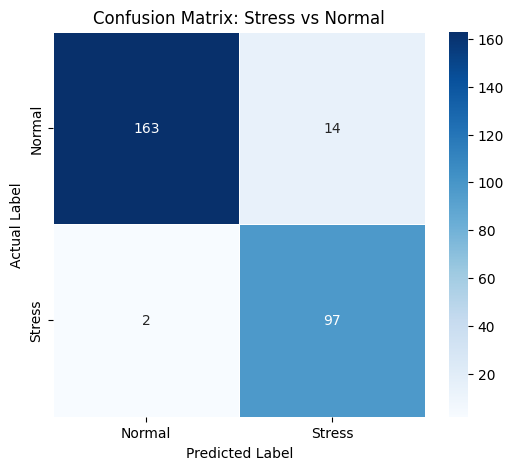

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame
df = pd.DataFrame({'Actual': all_labels.flatten(), 'Predicted': all_predictions.flatten()})

# Compute confusion matrix
cm = confusion_matrix(df['Actual'], df['Predicted'])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', linewidths=0.5, xticklabels=['Normal', 'Stress'], yticklabels=['Normal', 'Stress'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix: Stress vs Normal")
plt.show()


In [38]:
print("Train labels:", torch.unique(y_train, return_counts=True))
print("Test labels :", torch.unique(y_test, return_counts=True))

Train labels: (tensor([0., 1.]), tensor([1588,  893]))
Test labels : (tensor([0., 1.]), tensor([177,  99]))


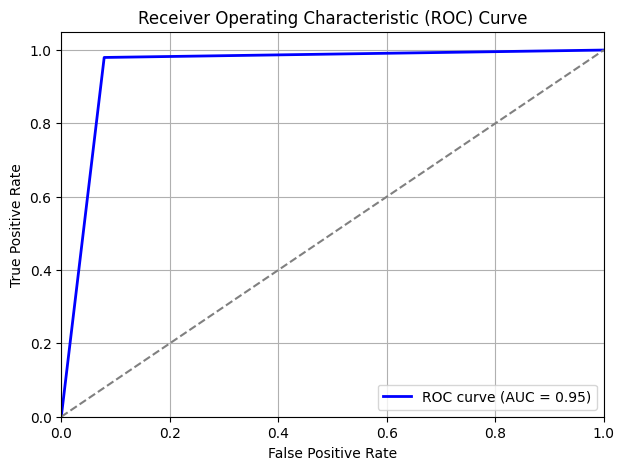

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure labels and predictions are binary (0 = Normal, 1 = Stress)
fpr, tpr, _ = roc_curve(all_labels.flatten(), all_predictions.flatten())  
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot the ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [46]:
torch.save(model.state_dict(),'LSTM_FCN_weights.pt')

In [48]:
print(model)

StressLSTM(
  (lstm): LSTM(4, 64, num_layers=4, batch_first=True)
  (lstm_dropout): Dropout(p=0.8, inplace=False)
  (conv1): Conv1d(4, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=192, out_features=1, bias=True)
)


In [54]:
# Assume X_train shape = (num_sequences, seq_len, 4)
X_flat = X_train.reshape(-1, X_train.shape[-1])  # Shape: (num_sequences * seq_len, 4)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_flat)

import joblib
joblib.dump(scaler, "input_FCN_scaler.pkl")


['input_FCN_scaler.pkl']

In [ ]:
%matplotlib widget


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.autolayout': True})
import ipywidgets as widgets
from IPython.display import display, clear_output
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    os.system('pip install ipympl -qq')
    %matplotlib widget


class StressViz:

    def __init__(
            self,
            dataset: Dataset,
            model: nn.Module,
    ):
        self.dataset = dataset
        self.model = model.eval().cpu()

    @torch.inference_mode()
    def viz_sample(
            self,
            idx: int,
    ):
        plt.close()
        (data, labels) = self.dataset[idx]
        data = data.unsqueeze(0)  # Add batch dimension
        labels = labels.numpy()

        pred= self.model(data)  # Get predictions

        # Plot true vs predicted stress levels
        plt.figure(figsize=(10, 5))
        plt.plot(labels, label="True Stress Level", linestyle="--", color="blue")
        plt.plot(pred.numpy().squeeze(), label="Predicted Stress Level", linestyle="-", color="red")
        plt.xlabel("Time Step")
        plt.ylabel("Stress Level")
        plt.title(f"True vs Predicted Stress for Sample {idx}")
        plt.legend()
        plt.grid(linestyle="--")
        plt.show()

    @torch.inference_mode()
    def viz_hr_eda(self, hr, eda):
        """
        Visualizes stress prediction evolution over time based on HR & EDA inputs.
        """
        seq_length = len(hr)
        hr = torch.tensor(hr, dtype=torch.float32).unsqueeze(1)  # Shape: (seq_len, 1)
        eda = torch.tensor(eda, dtype=torch.float32).unsqueeze(1)  # Shape: (seq_len, 1)
        data = torch.cat([hr, eda], dim=1).unsqueeze(0)  # Shape: (1, seq_len, 2)

        pred, _ = self.model(data)

        plt.figure(figsize=(10, 5))
        plt.plot(pred.numpy().squeeze(), label="Predicted Stress Level", linestyle="-", color="red")
        plt.xlabel("Time Step")
        plt.ylabel("Stress Level")
        plt.title("Predicted Stress Over Time")
        plt.legend()
        plt.grid(linestyle="--")
        plt.show()

    def run_interactive_viz(self):
        """
        Provides an interactive widget to adjust HR & EDA values and observe stress predictions.
        """

        self.hr_slider = widgets.FloatSlider(
            value=75, min=50, max=150, step=1, description="HR (bpm)", continuous_update=True
        )
        self.eda_slider = widgets.FloatSlider(
            value=0.5, min=0.1, max=2.0, step=0.05, description="EDA (μS)", continuous_update=True
        )

        def update_plot(hr, eda):
            """
            Callback function to update visualization based on HR & EDA slider values.
            """
            hr_values = [hr] * 50  # Simulate a short time series
            eda_values = [eda] * 50
            self.viz_hr_eda(hr_values, eda_values)

        widgets.interact(update_plot, hr=self.hr_slider, eda=self.eda_slider)

        clear_output(wait=True)
        display(self.hr_slider, self.eda_slider)

viz = StressViz(dataset=test_dataset, model=model)
viz.viz_sample(idx=1)  # Replace 5 with any sample index

In [ ]:
@torch.inference_mode()
def viz_hr_eda(self, chest_ecg_array, chest_eda_array, wrist_eda_array, wrist_HR_array):
    """
    Visualizes stress prediction evolution over time using all 4 input features.
    """
    seq_length = len(chest_eda)

    # Convert all to tensors with shape (seq_len, 1)
    chest_eda = torch.tensor(chest_eda_array, dtype=torch.float32).unsqueeze(1)
    chest_ecg = torch.tensor(chest_ecg_array, dtype=torch.float32).unsqueeze(1)
    wrist_eda = torch.tensor(wrist_eda_array, dtype=torch.float32).unsqueeze(1)
    wrist_hr  = torch.tensor(wrist_HR_array, dtype=torch.float32).unsqueeze(1)

    # Concatenate → shape: (seq_len, 4)
    data = torch.cat([chest_eda, chest_ecg, wrist_eda, wrist_hr], dim=1).unsqueeze(0)  # shape: (1, seq_len, 4)

    pred = self.model(data)
    if isinstance(pred, tuple):
        pred = pred[0]

    plt.figure(figsize=(10, 5))
    plt.plot(pred.numpy().squeeze(), label="Predicted Stress Level", linestyle="-", color="red")
    plt.xlabel("Time Step")
    plt.ylabel("Stress Level")
    plt.title("Predicted Stress Over Time")
    plt.legend()
    plt.grid(linestyle="--")
    plt.show()


In [ ]:
seq_len = 50
viz = StressViz(dataset=test_dataset, model=model)


# Simulated 50-timestep signals
chest_eda = np.random.normal(0.4, 0.05, seq_len)    # EDA in µS
chest_ecg = np.random.normal(0.9, 0.1, seq_len)     # Simulated ECG value
wrist_eda = np.random.normal(0.5, 0.05, seq_len)    # Wrist EDA
wrist_hr  = np.random.normal(75, 5, seq_len)        # HR in bpm

viz.viz_hr_eda(chest_eda, chest_ecg, wrist_eda, wrist_hr)


In [ ]:
class StressViz:

    def __init__(self, dataset: Dataset, model: nn.Module):
        self.dataset = dataset
        self.model = model.eval().cpu()

    @torch.inference_mode()
    def viz_hr_eda(self, chest_ecg_array, chest_eda_array, wrist_eda_array, wrist_HR_array):
        """
        Visualizes stress prediction evolution over time using all 4 input features.
        """
        seq_length = len(chest_eda_array)

        # Convert all to tensors with shape (seq_len, 1)
        chest_eda = torch.tensor(chest_eda_array, dtype=torch.float32).unsqueeze(1)
        chest_ecg = torch.tensor(chest_ecg_array, dtype=torch.float32).unsqueeze(1)
        wrist_eda = torch.tensor(wrist_eda_array, dtype=torch.float32).unsqueeze(1)
        wrist_hr  = torch.tensor(wrist_HR_array, dtype=torch.float32).unsqueeze(1)

        # Concatenate → shape: (seq_len, 4)
        data = torch.cat([chest_eda, chest_ecg, wrist_eda, wrist_hr], dim=1).unsqueeze(0)  # shape: (1, seq_len, 4)

        pred = self.model(data)
        if isinstance(pred, tuple):
            pred = pred[0]

        plt.figure(figsize=(10, 5))
        plt.plot(pred.numpy().squeeze(), label="Predicted Stress Level", linestyle="-", color="red")
        plt.xlabel("Time Step")
        plt.ylabel("Stress Level")
        plt.title("Predicted Stress Over Time")
        plt.legend()
        plt.grid(linestyle="--")
        plt.show()


In [ ]:
viz = StressViz(dataset=test_dataset, model=model)

# Simulated 50-timestep signals
seq_len = 60
chest_eda = np.random.normal(0.4, 0.05, seq_len)
chest_ecg = np.random.normal(0.9, 0.1, seq_len)
wrist_eda = np.random.normal(0.5, 0.05, seq_len)
wrist_hr  = np.random.normal(75, 5, seq_len)

viz.viz_hr_eda(chest_ecg, chest_eda, wrist_eda, wrist_hr)


In [ ]:
viz.run_interactive_viz()


In [ ]:
"""
Visualize the flow for arbitrary flow parameters amd number of time-steps.
You can see the effect of the flow parameter.
"""
if __name__ == '__main__':
    flow_viz = StressViz(test_dataset, model)
    viz.viz_hr_eda(chest_ecg, chest_eda, wrist_eda, wrist_hr)